In [1]:
import boto3
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import requests
import time

In [2]:
# NOTE: You will need to set AWS access keys for the MCP environment

In [2]:
%%time
client = boto3.client('logs', region_name='us-west-2')

query = """
fields @timestamp, @message
| filter @message like "cmr.search.api"
| filter @message like ":keyword"
| parse @message /:keyword "(?<keyword>.+)\*"/
| stats count(*) as number_queries by tolower(keyword)
| sort by number_queries desc
"""

print(query)
log_group = 'cmr-search-ops'
datetime_str = '10/01/22 00:00:00'
starting_datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')

start_query_response = client.start_query(
    logGroupName=log_group,
    startTime=int(starting_datetime_object.timestamp()),
    endTime=int(datetime.now().timestamp()),
    queryString=query,
)

query_id = start_query_response['queryId']

logs_response = None

while logs_response == None or logs_response['status'] == 'Running':
    print('Waiting for query to complete ...')
    time.sleep(10)
    logs_response = client.get_query_results(
        queryId=query_id
    )


fields @timestamp, @message
| filter @message like "cmr.search.api"
| filter @message like ":keyword"
| parse @message /:keyword "(?<keyword>.+)\*"/
| stats count(*) as number_queries by tolower(keyword)
| sort by number_queries desc

Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for quer

In [3]:
# Save the results so we don't have to re-run the query
filename = f"keyword_search-{query_id}.json"
with open(filename, "w+") as f:
    f.write(json.dumps(logs_response))
    f.close()

In [4]:
data = json.loads(open(filename).read())
data

{'results': [[{'field': 'tolower(keyword)', 'value': 'biomass'},
   {'field': 'number_queries', 'value': '74'}],
  [{'field': 'tolower(keyword)', 'value': 'gedi'},
   {'field': 'number_queries', 'value': '55'}],
  [{'field': 'tolower(keyword)', 'value': 'gedi* l1b'},
   {'field': 'number_queries', 'value': '36'}],
  [{'field': 'tolower(keyword)', 'value': 'gedi* l2b'},
   {'field': 'number_queries', 'value': '24'}],
  [{'field': 'tolower(keyword)',
    'value': 'global* ecosystem* dynamics* investigation* (gedi)* calibration/validation'},
   {'field': 'number_queries', 'value': '23'}],
  [{'field': 'tolower(keyword)',
    'value': 'global* 25m* resolution* palsar-2/palsar* forest/non-forest* map'},
   {'field': 'number_queries', 'value': '22'}],
  [{'field': 'tolower(keyword)',
    'value': 'global* ecosystem* dynamics* investigation* (gedi)* calibration/validation* airborne* lidar* dataset'},
   {'field': 'number_queries', 'value': '19'}],
  [{'field': 'number_queries', 'value': '19'}

In [5]:
restructured_data = []
for result in logs_response['results']:
    entry_data = {}
    for entry in result:
        entry_data[entry['field']] = entry['value']
    restructured_data.append(entry_data)

restructured_data

[{'tolower(keyword)': 'biomass', 'number_queries': '74'},
 {'tolower(keyword)': 'gedi', 'number_queries': '55'},
 {'tolower(keyword)': 'gedi* l1b', 'number_queries': '36'},
 {'tolower(keyword)': 'gedi* l2b', 'number_queries': '24'},
 {'tolower(keyword)': 'global* ecosystem* dynamics* investigation* (gedi)* calibration/validation',
  'number_queries': '23'},
 {'tolower(keyword)': 'global* 25m* resolution* palsar-2/palsar* forest/non-forest* map',
  'number_queries': '22'},
 {'tolower(keyword)': 'global* ecosystem* dynamics* investigation* (gedi)* calibration/validation* airborne* lidar* dataset',
  'number_queries': '19'},
 {'number_queries': '19'},
 {'tolower(keyword)': 'afrisar', 'number_queries': '18'},
 {'tolower(keyword)': 'globcover* global* land* cover* product',
  'number_queries': '18'},
 {'tolower(keyword)': 'nisar', 'number_queries': '18'},
 {'tolower(keyword)': 'gedi* l2a', 'number_queries': '17'},
 {'tolower(keyword)': 'gedi02', 'number_queries': '16'},
 {'tolower(keyword)'

In [6]:
count_data = {}

for result in restructured_data:
    if 'tolower(keyword)' in result:
        count_data[result['tolower(keyword)']] = int(result['number_queries'])

count_data = {k: v for k, v in sorted(count_data.items(), key=lambda item: item[1], reverse=True)}
count_data

{'biomass': 74,
 'gedi': 55,
 'gedi* l1b': 36,
 'gedi* l2b': 24,
 'global* ecosystem* dynamics* investigation* (gedi)* calibration/validation': 23,
 'global* 25m* resolution* palsar-2/palsar* forest/non-forest* map': 22,
 'global* ecosystem* dynamics* investigation* (gedi)* calibration/validation* airborne* lidar* dataset': 19,
 'afrisar': 18,
 'globcover* global* land* cover* product': 18,
 'nisar': 18,
 'gedi* l2a': 17,
 'gedi02': 16,
 'gedi* l3': 14,
 'agb': 14,
 'atl03': 14,
 'gedi* l4a': 13,
 'l2b': 10,
 'afrisar* uavsar* ungeocoded* covariance* matrix* product* generated* using* nisar* tools': 10,
 'sentinel-1a* dual-pol* ground* projected* high* and* full* resolution* images': 9,
 'sentinel': 9,
 'global* forest* change* 2000-2017': 8,
 'l4b': 8,
 'gedi* l2a* version* 2': 6,
 'atl08': 6,
 'global* ecosystem': 6,
 'lvis': 6,
 'afrisar_dlr': 6,
 'globcover': 5,
 'lvis* facility* l1b* geolocated* return* energy* waveforms* v001': 5,
 'gedi* 02': 5,
 'icesat-2': 5,
 'gedi* l4b': 5,


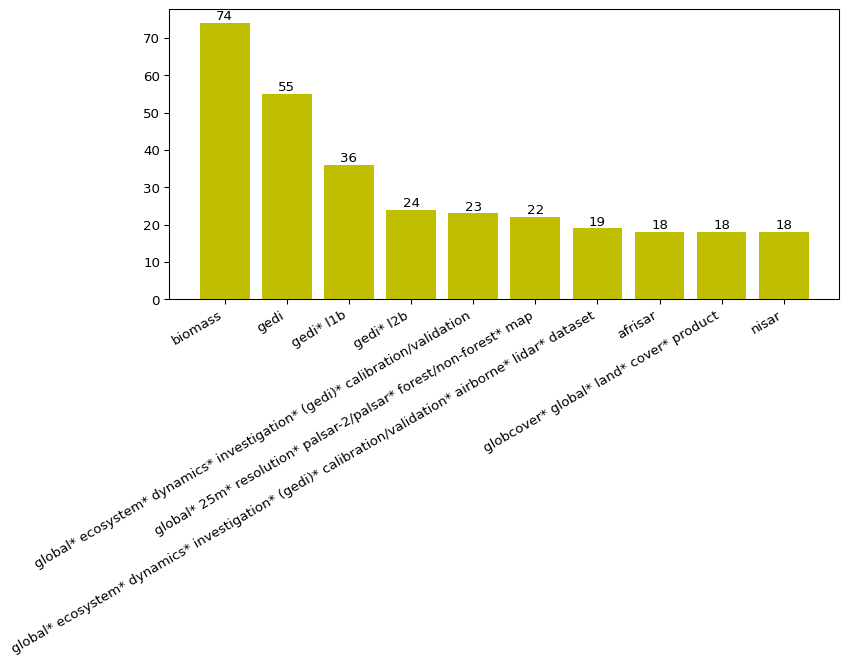

In [7]:
# data set
limit = 10
keywords = list(count_data.keys())[0:limit]
number_queries = list(count_data.values())[0:limit]

plt.figure(figsize=(9, 4), dpi=96)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', va= 'bottom')

plt.bar(keywords, number_queries, color='y')
addlabels(keywords, number_queries)
plt.xticks(rotation=30, ha='right')
plt.show()